# Market Basket Analysis

In [1]:
#%pip install -q efficient_apriori

In [2]:
import efficient_apriori
from efficient_apriori import apriori
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import combinations

In [3]:
aisles = pd.read_csv('/data_analyst/python/cap07/aisles.csv')
departments = pd.read_csv('/data_analyst/python/cap07/departments.csv')
order_trains = pd.read_csv('/data_analyst/python/cap07/order_products__train.csv')
order_prior = pd.read_csv('/data_analyst/python/cap07/order_products__prior.csv')
orders = pd.read_csv('/data_analyst/python/cap07/orders.csv')
products = pd.read_csv('/data_analyst/python/cap07/products.csv')
sample = pd.read_csv('/data_analyst/python/cap07/sample_submission.csv')

# Análise Exploratória

# Exploratory Analysis

In [4]:
aisles.shape

(134, 2)

In [5]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [6]:
departments.shape

(21, 2)

In [7]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [8]:
products.shape

(49688, 4)

In [9]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [10]:
orders.shape

(3421083, 7)

In [11]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [12]:
order_trains.shape

(1384617, 4)

In [13]:
order_trains.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [14]:
order_prior.shape

(32434489, 4)

In [15]:
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [16]:
# Total de registros por dataset # Total of registries per dataset
total = np.array([['Aisles', len(aisles)],
['Departments', len(departments)],
['Product', len(products)],
['Order', len(orders)],
['Order_Prior', len(order_prior)],
['Order_Train', len(order_trains)]])

total_count = pd.DataFrame(total, columns=['Arquivo', 'Total de Registros'])
total_count

,Arquivo,Total de Registros
0,Aisles,134
1,Departments,21
2,Product,49688
3,Order,3421083
4,Order_Prior,32434489
5,Order_Train,1384617


In [17]:
orders['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

# Limpeza de Dados

# Data Cleaning

In [18]:
aisles.isna().sum()

aisle_id    0
aisle       0
dtype: int64

In [19]:
departments.isna().sum()

department_id    0
department       0
dtype: int64

In [20]:
# Os valores ausentes na coluna 'days_since_prior_order' significam que essas foram a primera compra desses clientes. Não é exatamente um erro do dataset
# NA values on 'days_since_prior_order' mean it's the clients first purchase. Not exactly an error.
orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [21]:
order_prior.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [22]:
order_trains.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [23]:
products.isna().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

# Feature Extraction

Juntando os datasets para melhor análise

Merging the datasets for better analysis

In [24]:
order_prior = order_prior.merge(orders, on ='order_id', how = 'left')
order_prior = order_prior.merge(products, on ='product_id', how = 'left')
order_prior = order_prior.merge(aisles, on ='aisle_id', how = 'left')
order_prior = order_prior.merge(departments, on ='department_id', how = 'left')

In [25]:
order_prior.head(5)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry


In [26]:
order_prior.isna().sum()

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
dtype: int64

In [27]:
order_prior.isnull().sum() / len(order_prior) * 100

order_id                  0.00000
product_id                0.00000
add_to_cart_order         0.00000
reordered                 0.00000
user_id                   0.00000
eval_set                  0.00000
order_number              0.00000
order_dow                 0.00000
order_hour_of_day         0.00000
days_since_prior_order    6.40697
product_name              0.00000
aisle_id                  0.00000
department_id             0.00000
aisle                     0.00000
department                0.00000
dtype: float64

In [28]:
order_trains = order_trains.merge(orders, on ='order_id', how='left')
order_trains = order_trains.merge(products, on ='product_id', how='left')
order_trains = order_trains.merge(aisles, on ='aisle_id', how='left')
order_trains = order_trains.merge(departments, on ='department_id', how='left')

In [29]:
order_trains.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods


In [30]:
order_trains.isna().sum()

order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_name              0
aisle_id                  0
department_id             0
aisle                     0
department                0
dtype: int64

Agora será feito o agrupamento dos dados e a preparação do dataset para que esteja no formato esperado pelo algoritimo apriori

Now we'll group the data and prepare the dataset to the expected format for apriori

In [31]:
grouped_order = pd.DataFrame(order_prior.groupby('order_id')['product_id'])

In [32]:
grouped_order.shape

(3214874, 2)

In [33]:
prod = []

In [34]:
for i in range(len(grouped_order[0])):
    prod.append(list(grouped_order.iloc[i][1]))

In [35]:
produto = prod

In [36]:
order = grouped_order[0]

In [37]:
# Preparando o DataFrame
transaction = pd.DataFrame({'OrderId': order, 'Products': produto})

In [38]:
transaction.head()

,OrderId,Products
0,2,"[33120, 28985, 9327, 45918, 30035, 17794, 4014..."
1,3,"[33754, 24838, 17704, 21903, 17668, 46667, 174..."
2,4,"[46842, 26434, 39758, 27761, 10054, 21351, 225..."
3,5,"[13176, 15005, 47329, 27966, 23909, 48370, 132..."
4,6,"[40462, 15873, 41897]"


# Analise Estatística Descritiva

Learning and understanding the dataset.
What's the most frequent number of purchases?

Descobrindo o dataset. 
Qual o número mais frequente de compras?

In [41]:
# Agrupando os dados por usuário e número de pedidos, agregando pelo maior valor
# Grouping the data by user and number of purchases, ordering by the highest value.

max_count = orders.groupby('user_id')['order_number'].aggregate(np.max).reset_index()
max_count.head()

,user_id,order_number
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5


In [42]:
# Counting by the number of purchases
# Contando pelo número de pedidos

max_count = max_count.order_number.value_counts()
max_count.head()

4    23986
5    19590
6    16165
7    13850
8    11700
Name: order_number, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

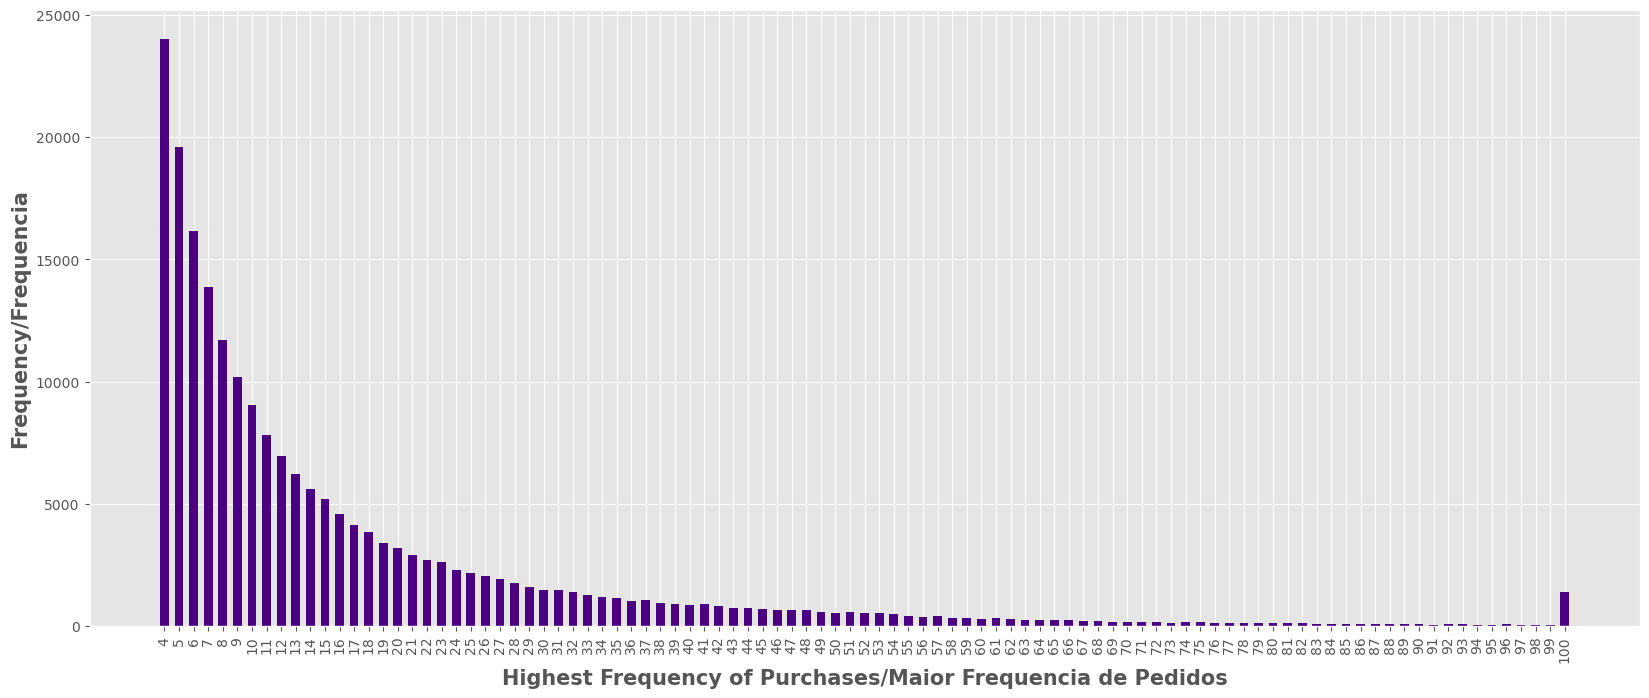

In [44]:
plt.style.use('ggplot')
plt.figure(figsize=(20,8))
plt.bar(max_count.index, max_count.values, color = 'indigo', width = 0.6)
plt.xticks(max_count.index, rotation='vertical')
plt.ylabel('Frequency/Frequencia', fontsize= 15, fontweight= 'bold')
plt.xlabel('Highest Frequency of Purchases/Maior Frequencia de Pedidos', fontsize= 15, fontweight= 'bold')
plt.show

Which day of the week has more purchases?

Qual dia da semana tem mais pedidos?

In [46]:
x = [0, 1, 2, 3, 4, 5, 6]
y = [orders[orders['order_dow']==0].shape[0],
    orders[orders['order_dow']==1].shape[0],
    orders[orders['order_dow']==2].shape[0],
    orders[orders['order_dow']==3].shape[0],
    orders[orders['order_dow']==4].shape[0],
    orders[orders['order_dow']==5].shape[0],
    orders[orders['order_dow']==6].shape[0]]

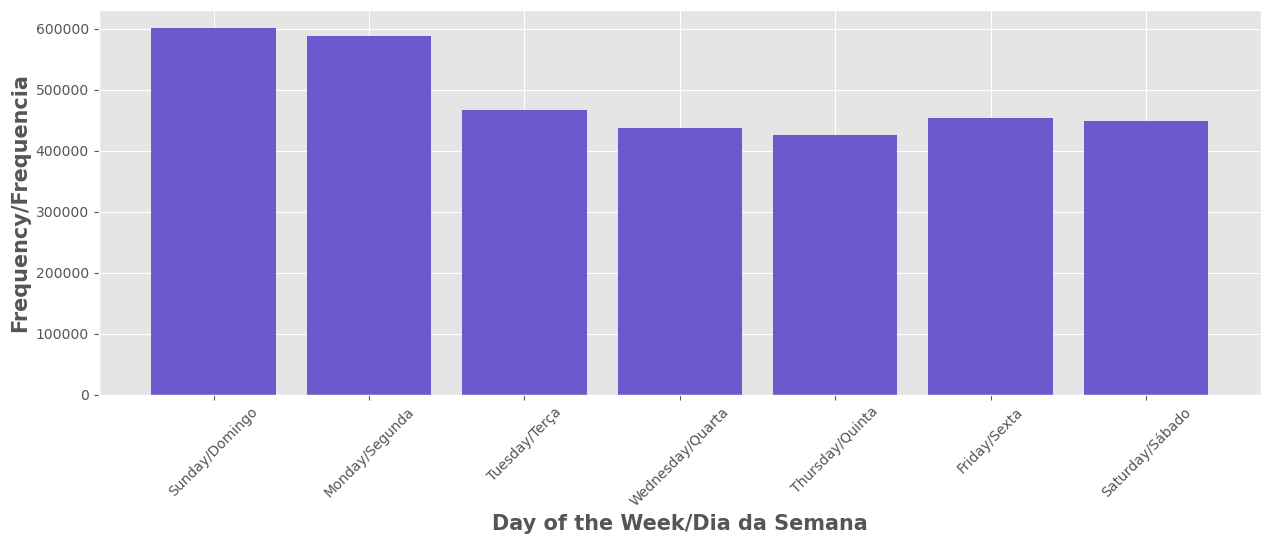

In [50]:
plt.figure(figsize=(15,5))
plt.bar(x,y, color = 'slateblue')
plt.xlabel('Day of the Week/Dia da Semana', fontsize = 15, fontweight = 'bold')
plt.ylabel('Frequency/Frequencia', fontsize = 15, fontweight = 'bold')
plt.xticks(x,['Sunday/Domingo', 'Monday/Segunda', 'Tuesday/Terça', 'Wednesday/Quarta', 'Thursday/Quinta', 'Friday/Sexta', 'Saturday/Sábado'], rotation = 45)
plt.show()

What time of the day has the most purchases?

Que hora do dia tem mais números de pedidos?

In [51]:
x = list(range(0,24))
y = []

for i in range(0,24):
    y.append(orders[orders['order_hour_of_day']==i].shape[0])

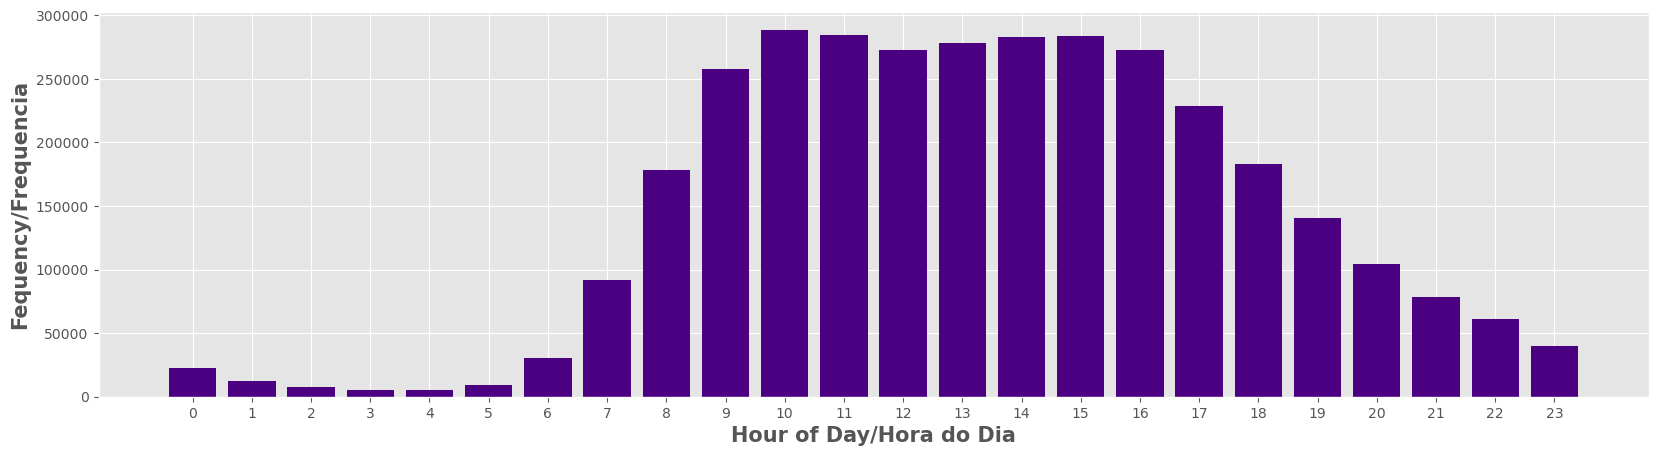

In [53]:
plt.figure(figsize=(20,5))
plt.bar(x,y, color='indigo')
plt.xticks(np.arange(0,24,1))
plt.xlabel('Hour of Day/Hora do Dia', fontsize=15, fontweight='bold') 
plt.ylabel('Fequency/Frequencia', fontsize=15, fontweight='bold') 
plt.show()

Which department has more purchases?

Qual departamento tem mais pedidos?

In [54]:
departments_count = order_prior['department'].value_counts()

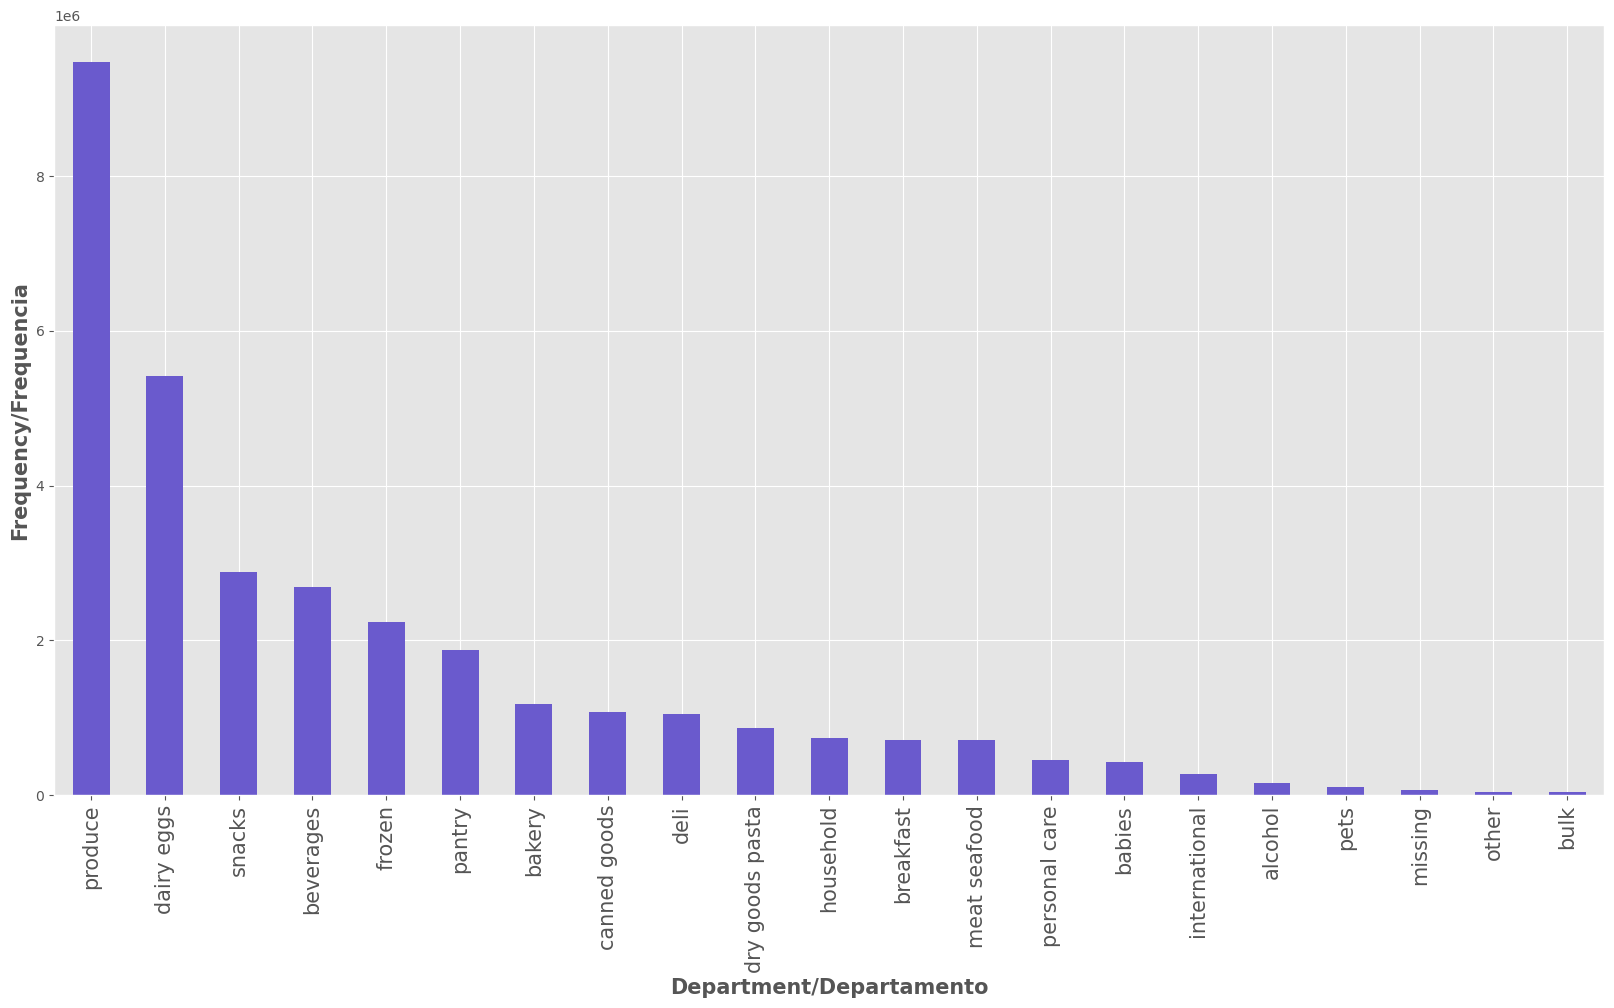

In [62]:
plt.figure(figsize=(20,10))
departments_count.plot(kind = 'bar', color='slateblue')
plt.xticks(rotation = 90, fontsize=15)
plt.xlabel('Department/Departamento', fontsize=15, fontweight='bold') 
plt.ylabel('Frequency/Frequencia', fontsize=15, fontweight='bold') 
plt.show()

Which are the 20 principal aisles by purchase frequency?

Quais são os 20 corredores principais, baseados na frequencia de pedidos?

In [63]:
aisle_count = order_prior['aisle'].value_counts()

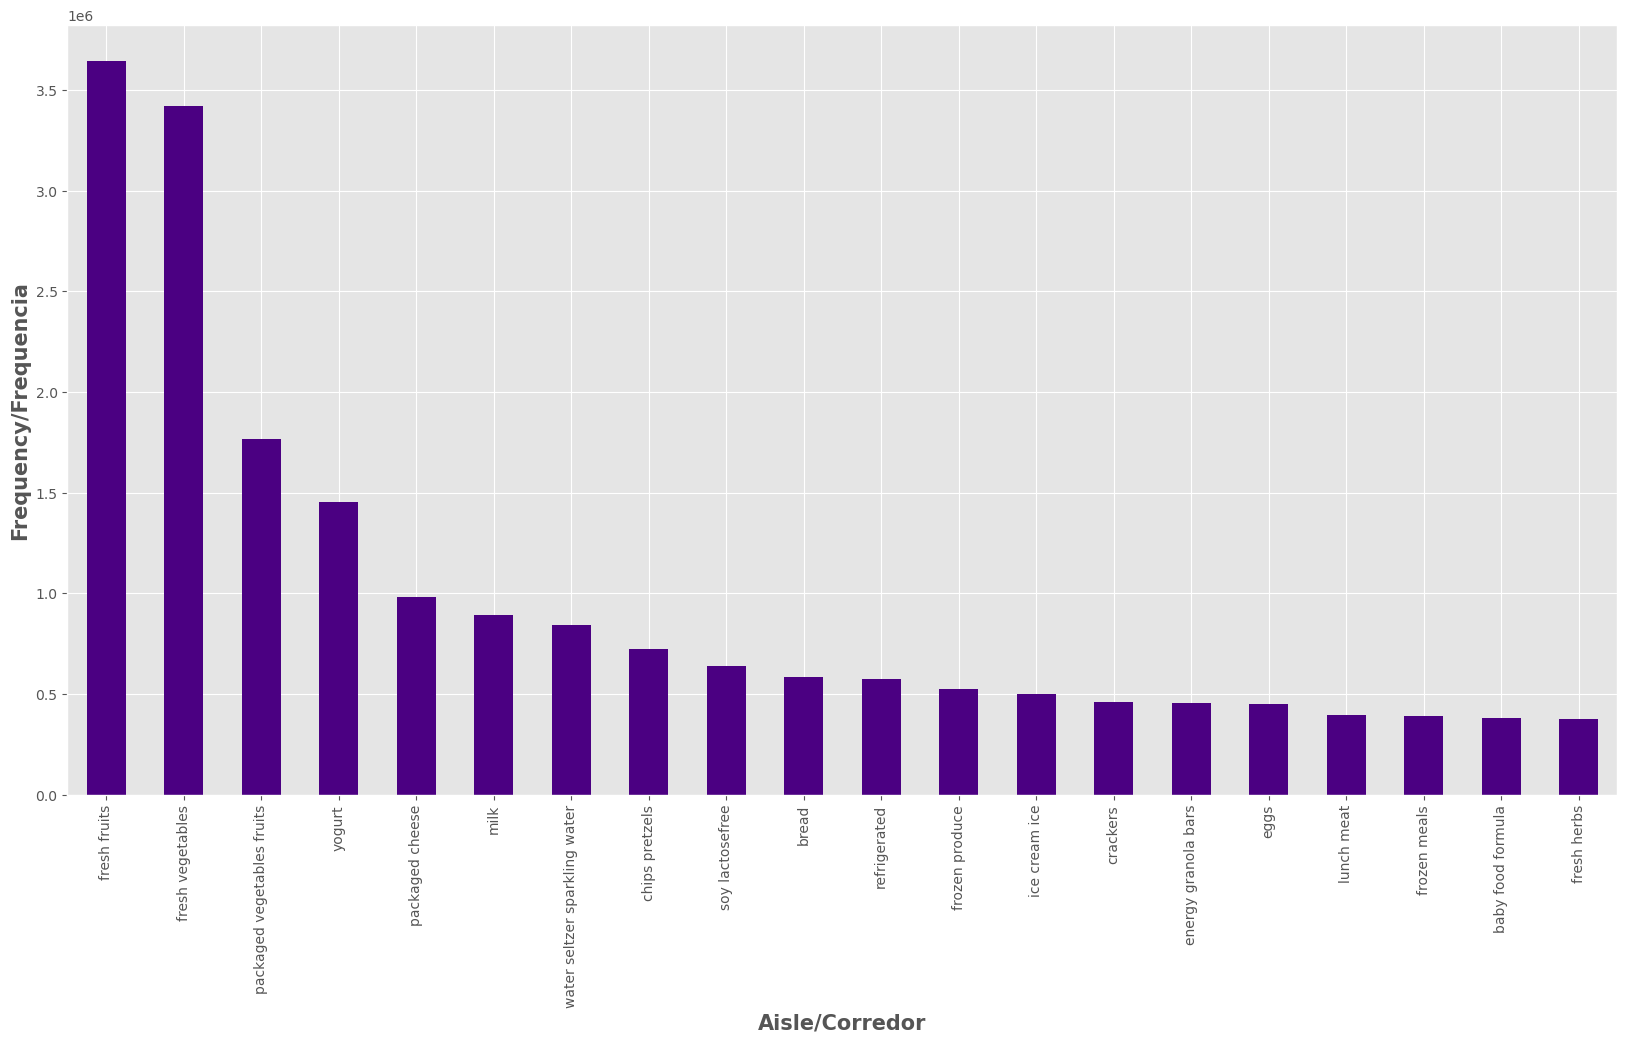

In [67]:
plt.figure(figsize=(20,10))
aisle_count[0:20].plot(kind='bar', color='indigo') 
plt.xlabel('Aisle/Corredor', fontsize=15, fontweight='bold') 
plt.ylabel('Frequency/Frequencia', fontsize=15, fontweight='bold') 
plt.xticks(rotation=90)
plt.show()

Which are the top 20 products by purchase frequency?

Quais são os 20 principais produtos por frequencia de pedido?

In [68]:
products_count = order_prior['product_name'].value_counts() 

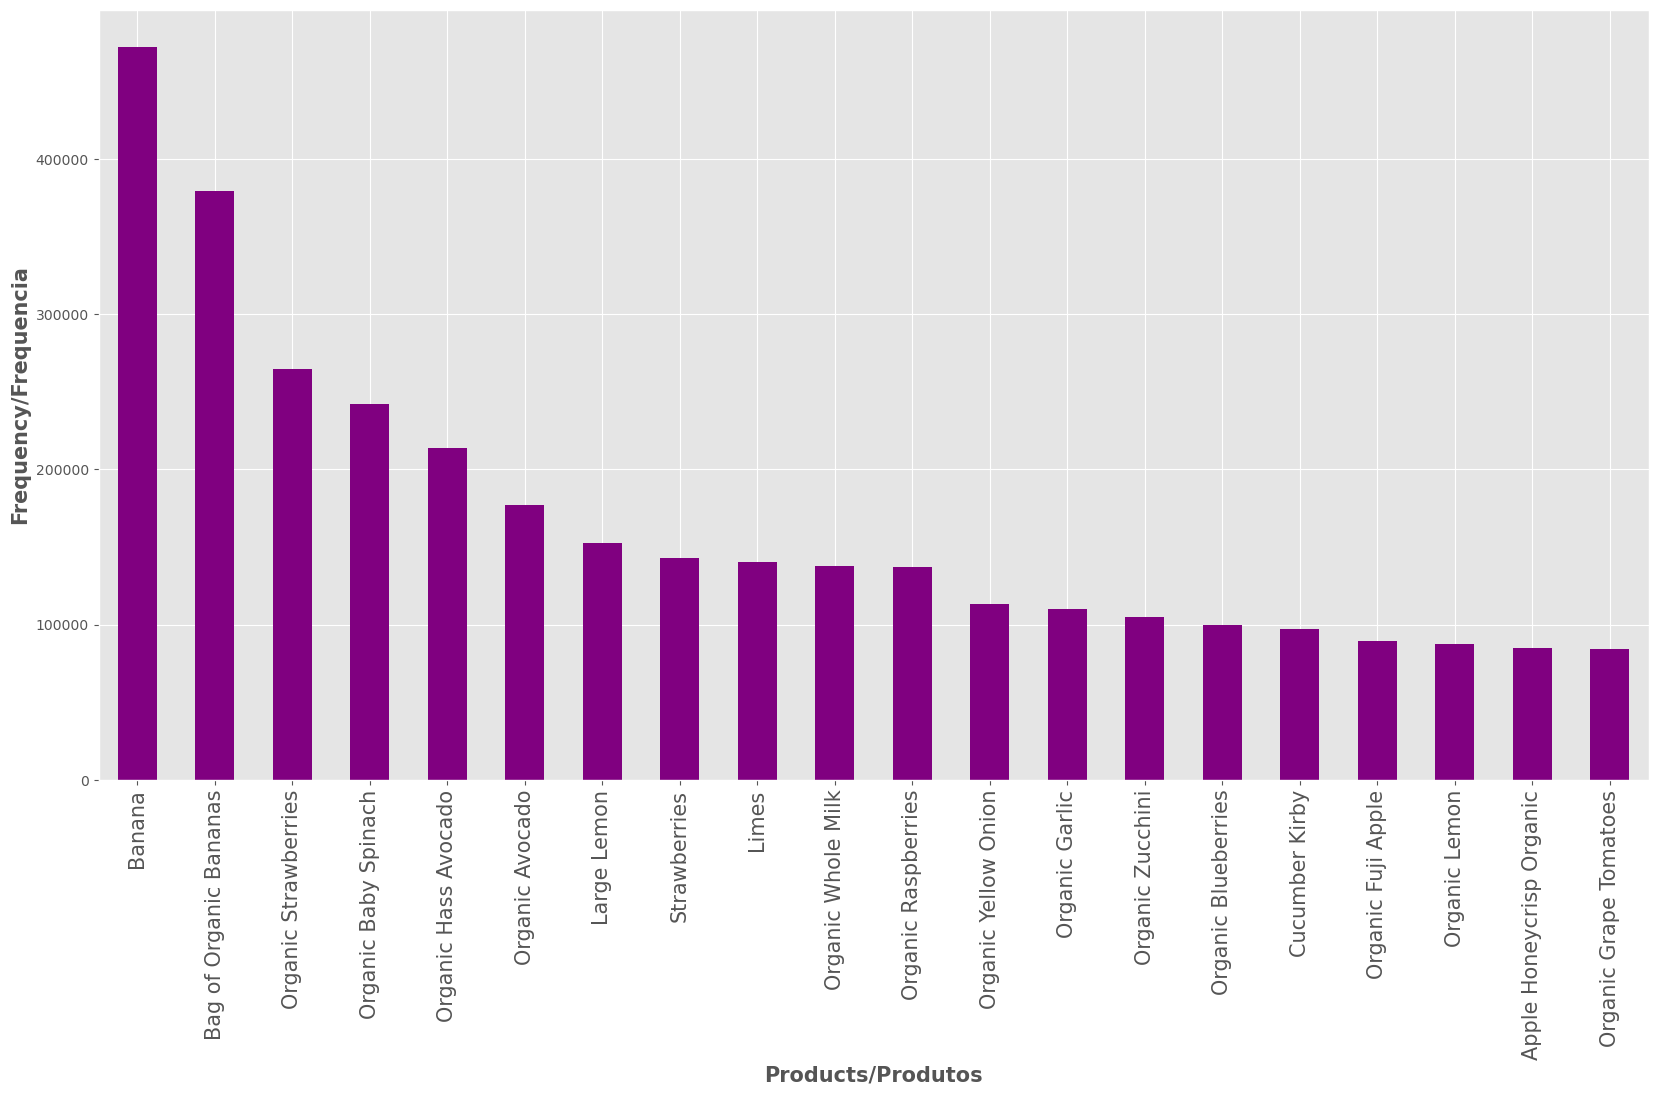

In [71]:
plt.figure(figsize=(20,10))
products_count[0:20].plot(kind='bar', color='purple') 
plt.xticks(rotation=90, fontsize=15)
plt.xlabel('Products/Produtos', fontsize=15, fontweight='bold') 
plt.ylabel('Frequency/Frequencia', fontsize=15, fontweight='bold')
plt.show()


Analysing similarity of different purchases

Analisando semelhanças em compras diferentes

In [72]:
temp_df = order_prior.groupby('product_name')['reordered'].agg(['count', 'sum']).rename(columns = {'count':'total', 'sum':'reordered'})
temp_df = temp_df.sort_values('total', ascending=False).reset_index()

In [75]:
labels = list(temp_df.product_name[0:20])
reorder = list(temp_df.reordered[0:20])
total = list(temp_df.total[0:20])

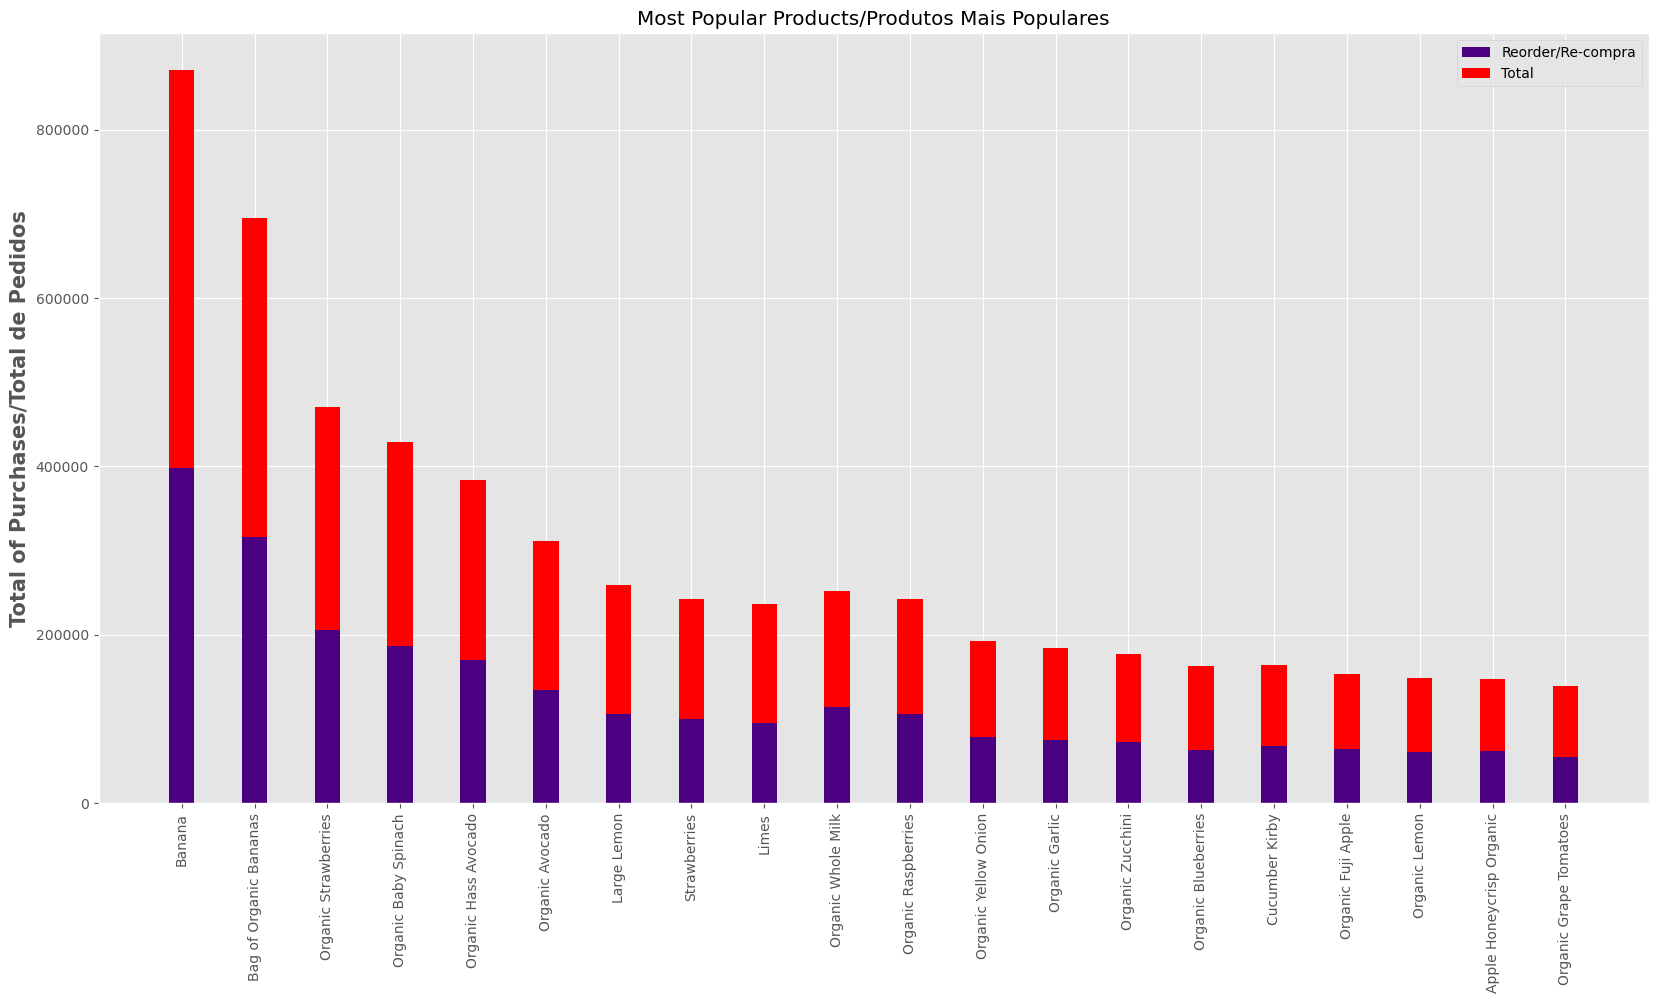

In [77]:
width = 0.35
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(labels, reorder, width, label ='Reorder/Re-compra', color='indigo')
ax.bar(labels, total, width, bottom= reorder, label='Total', color='red')
ax.set_ylabel('Total of Purchases/Total de Pedidos', fontsize=15, fontweight='bold')
ax.legend()
ax.set_title('Most Popular Products/Produtos Mais Populares')
plt.xticks(rotation=90)
plt.show()

Reorders Analysis by Departments Over Time 

Analisando as Re-Compras por Departamento ao Longo do Tempo

In [78]:
grouped_df = order_prior.groupby('department')['reordered'].agg('mean').reset_index()
grouped_df.head()

,department,reordered
0,alcohol,0.569924
1,babies,0.578971
2,bakery,0.628141
3,beverages,0.653460
4,breakfast,0.560922


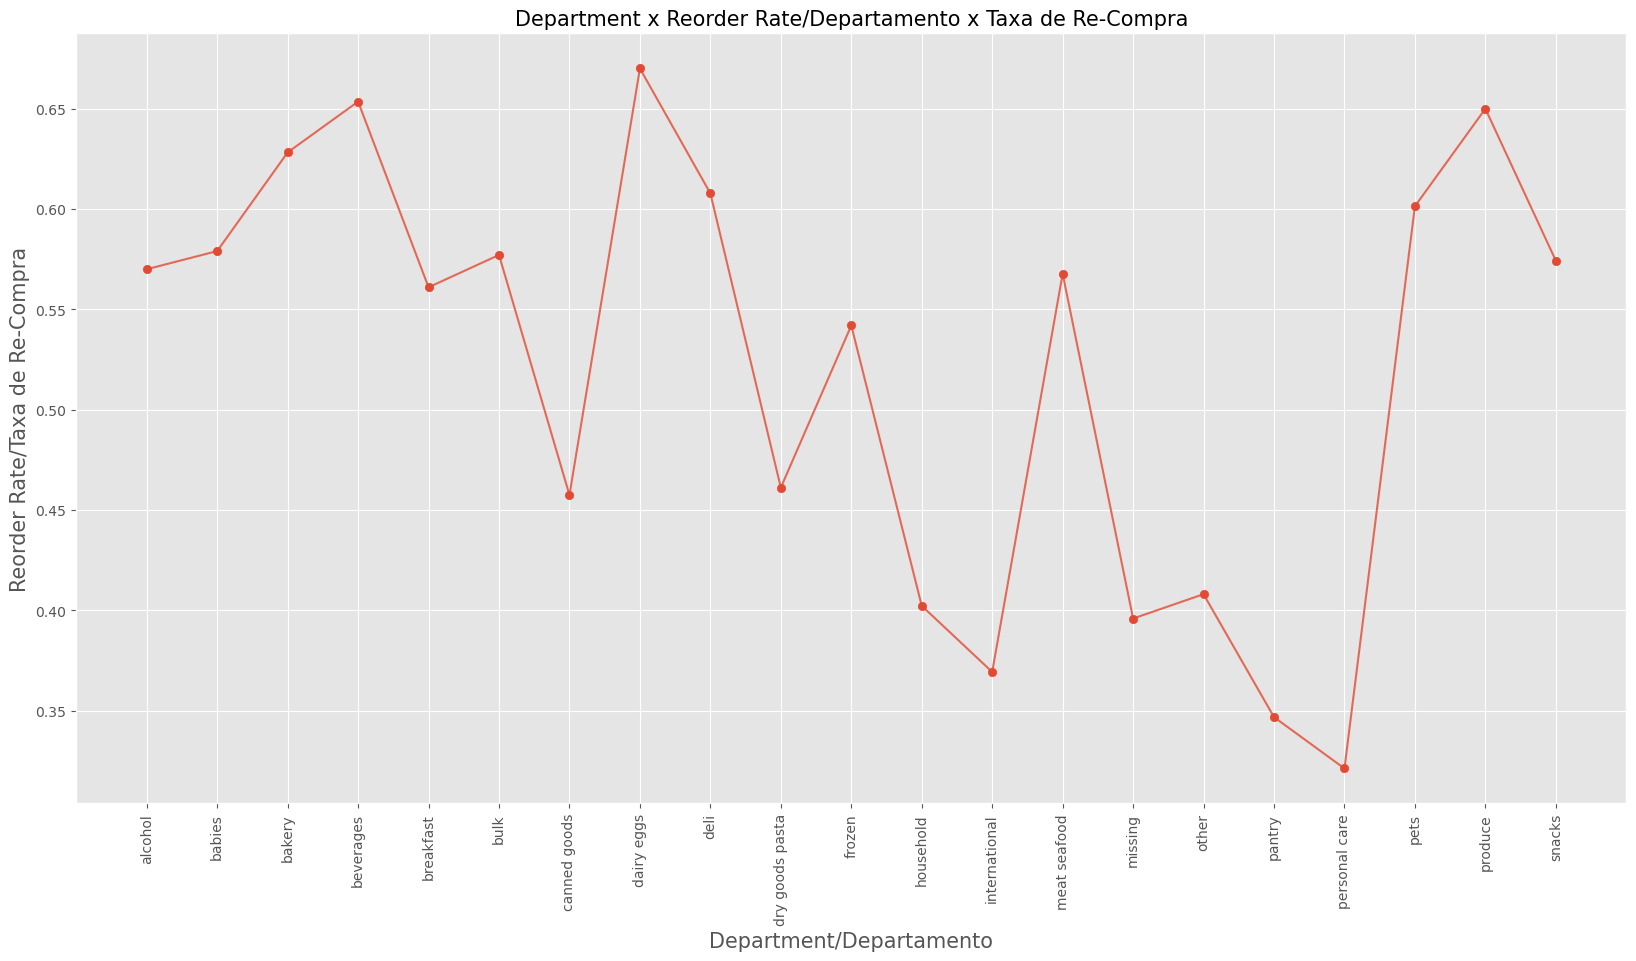

In [80]:
plt.figure(figsize=(20,10))
plt.plot(list(grouped_df['department']), grouped_df['reordered'].values, alpha=0.8)
plt.scatter(list(grouped_df['department']), grouped_df['reordered'].values)
plt.ylabel('Reorder Rate/Taxa de Re-Compra', fontsize=15)
plt.xlabel('Department/Departamento', fontsize=15)
plt.title('Department x Reorder Rate/Departamento x Taxa de Re-Compra', fontsize=15)
plt.xticks(rotation=90)
plt.show()

Reorders and Orders Analysis

Analise de Compras e Re-Compras

In [81]:
temp_df = order_prior.groupby('department')['reordered'].agg(['count', 'sum']).rename(columns = {'count':'total', 'sum':'reordered'})
temp_df = temp_df.sort_values('total', ascending=False).reset_index()

In [84]:
labels = list(temp_df.department[0:20])
reorder = list(temp_df.reordered[0:20])
total = list(temp_df.total[0:20])

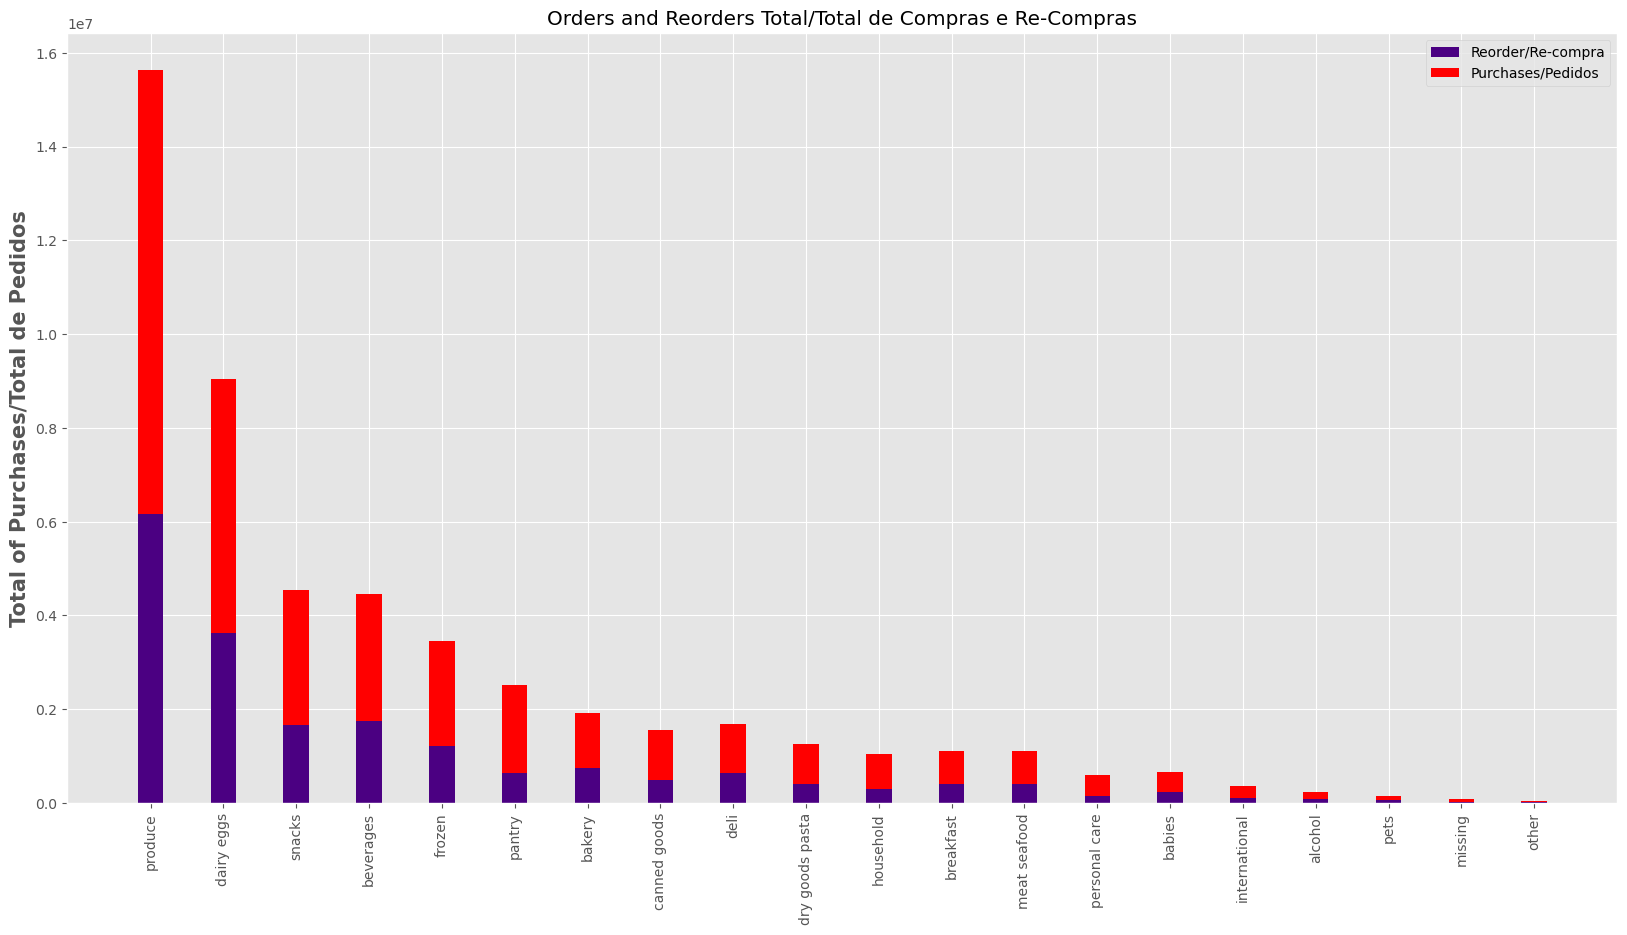

In [85]:
width = 0.35
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(labels, reorder, width, label ='Reorder/Re-compra', color='indigo')
ax.bar(labels, total, width, bottom= reorder, label='Purchases/Pedidos', color='red')
ax.set_ylabel('Total of Purchases/Total de Pedidos', fontsize=15, fontweight='bold')
ax.legend()
ax.set_title('Orders and Reorders Total/Total de Compras e Re-Compras')
plt.xticks(rotation=90)
plt.show()

Reorder Analysis by Aisle

Análise de Re-Compra por Corredor

In [105]:
grouped_df = order_prior.groupby('aisle')['reordered'].agg(['mean']).reset_index()

In [107]:
list(grouped_df['aisle'])[0:20]


['air fresheners candles',
 'asian foods',
 'baby accessories',
 'baby bath body care',
 'baby food formula',
 'bakery desserts',
 'baking ingredients',
 'baking supplies decor',
 'beauty',
 'beers coolers',
 'body lotions soap',
 'bread',
 'breakfast bakery',
 'breakfast bars pastries',
 'bulk dried fruits vegetables',
 'bulk grains rice dried goods',
 'buns rolls',
 'butter',
 'candy chocolate',
 'canned fruit applesauce']

In [108]:
list(grouped_df['mean'])[0:20]

[0.309052440683089,
 0.35113170515044384,
 0.5509803921568628,
 0.29576972380841393,
 0.5902587487188069,
 0.4991253477101316,
 0.3050824629926659,
 0.16722944453824076,
 0.21206225680933852,
 0.5653040672462338,
 0.3293759811616955,
 0.6701679450921116,
 0.651222235514615,
 0.5859031450041747,
 0.6203938277291571,
 0.5332752106945655,
 0.5308410388001593,
 0.5760369932013982,
 0.5732931426271014,
 0.5630124889617762]

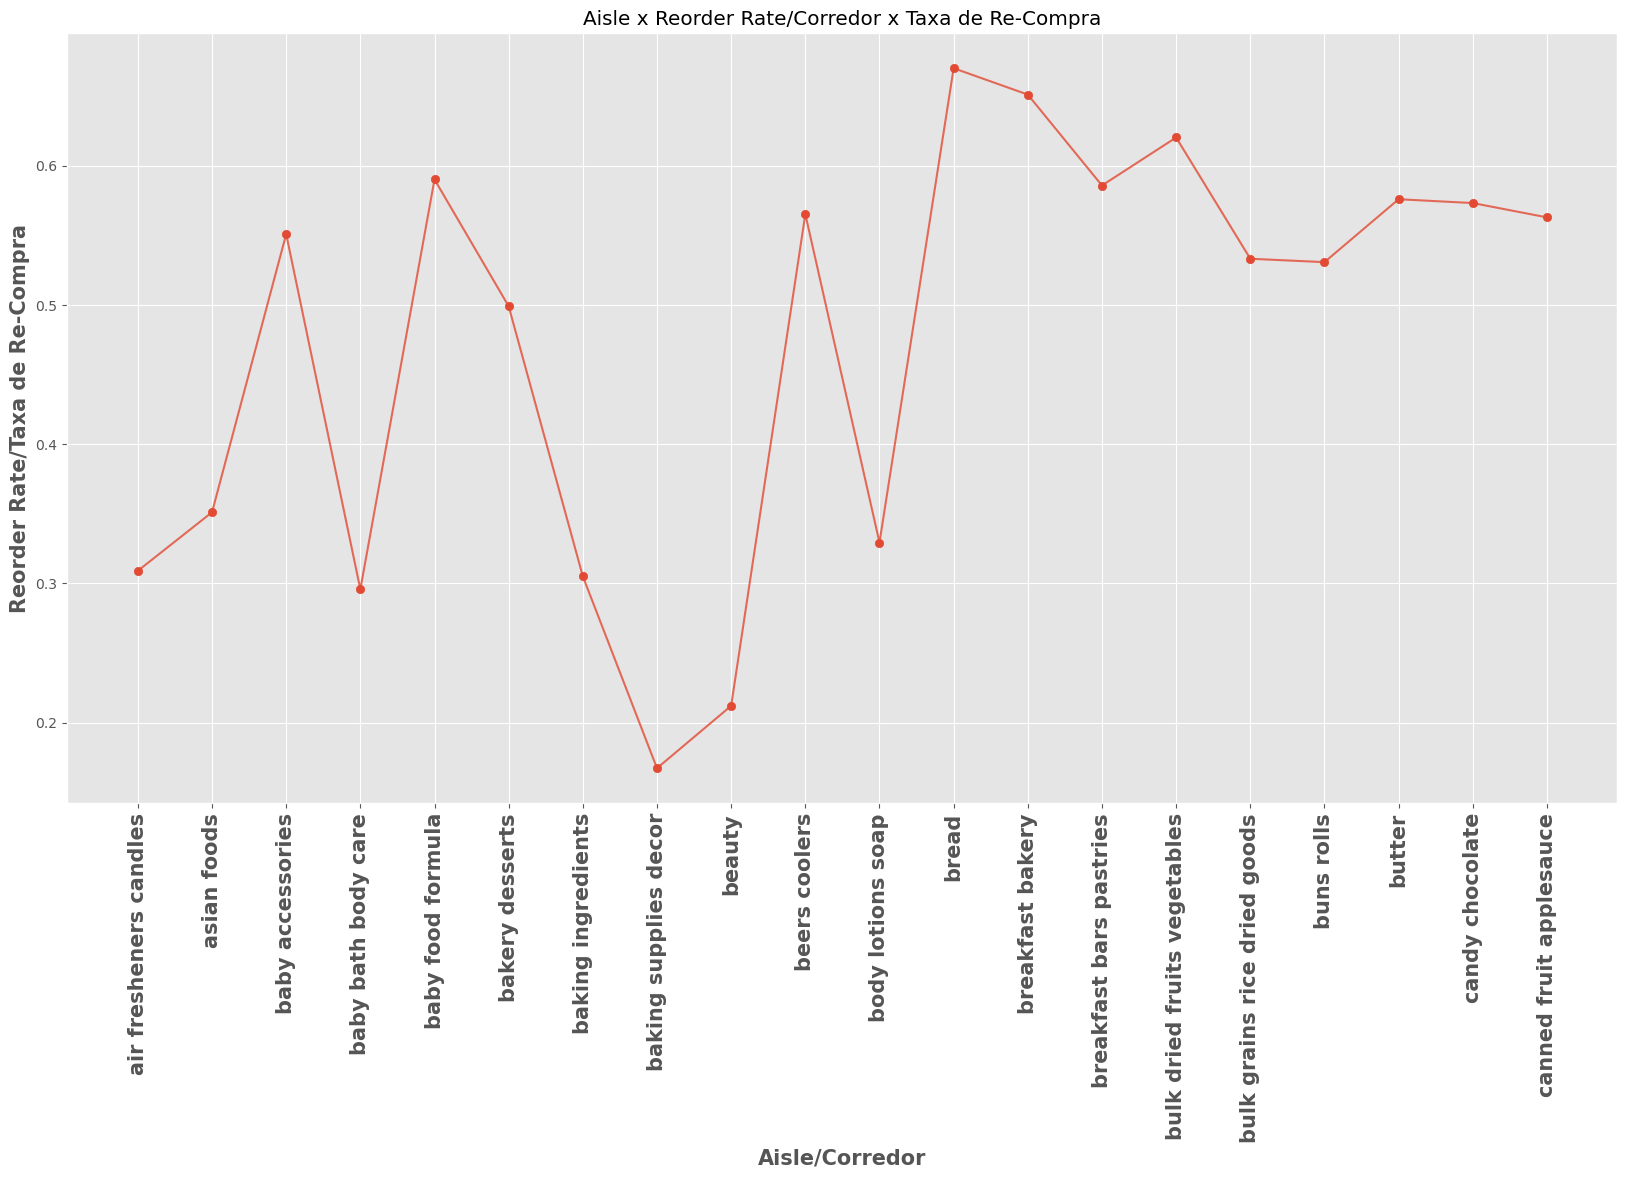

In [112]:
plt.figure(figsize=(20,10))
plt.plot(list(grouped_df['aisle'])[0:20], grouped_df['mean'].values[0:20], alpha=0.8)
plt.scatter(list(grouped_df['aisle'])[0:20], grouped_df['mean'].values[0:20])
plt.ylabel('Reorder Rate/Taxa de Re-Compra', fontsize=15, fontweight='bold')
plt.xlabel('Aisle/Corredor', fontsize=15, fontweight='bold')
plt.title('Aisle x Reorder Rate/Corredor x Taxa de Re-Compra')
plt.xticks(rotation=90, fontsize=15, fontweight='bold')
plt.show()


Reorder Analysis by Aisle (Total)

Análise de Re-Compra por Corredor (Total)

In [113]:
temp_df = order_prior.groupby('aisle')['reordered'].agg(['count', 'sum']).rename(columns = {'count':'total', 'sum':'reordered'})
temp_df = temp_df.sort_values('total', ascending=False).reset_index()

In [115]:
labels = list(temp_df.aisle[0:20])
reorder = list(temp_df.reordered[0:20])
total = list(temp_df.total[0:20])

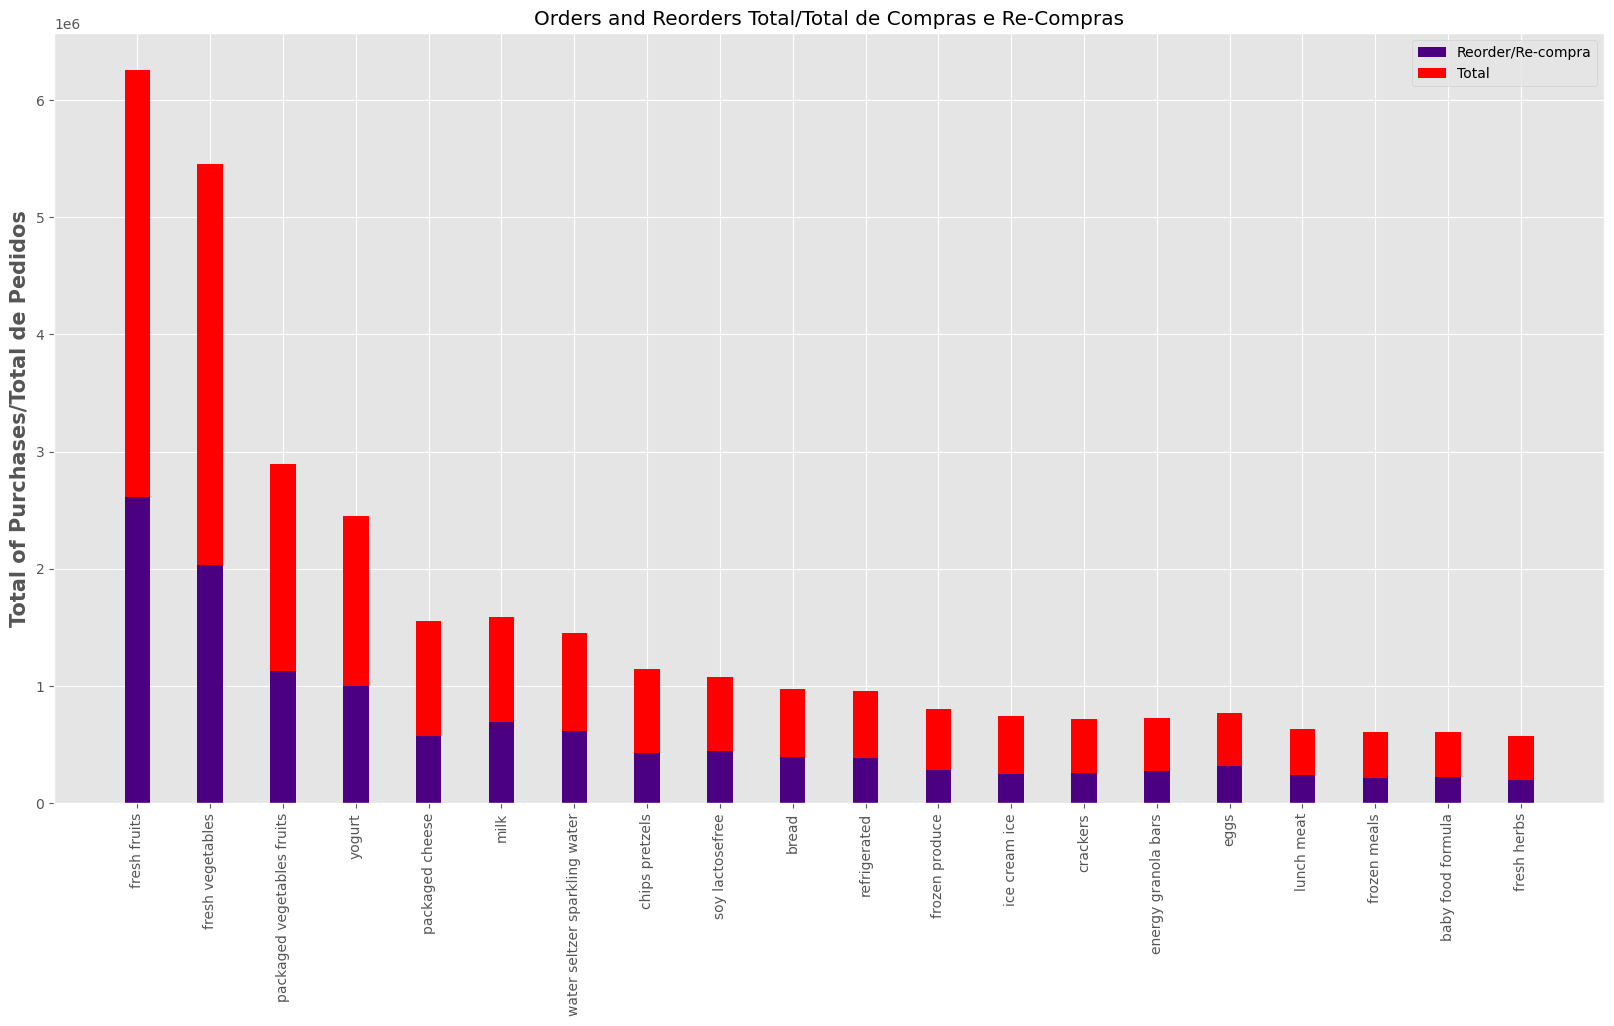

In [116]:
width = 0.35
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(labels, reorder, width, label ='Reorder/Re-compra', color='indigo')
ax.bar(labels, total, width, bottom= reorder, label='Total', color='red')
ax.set_ylabel('Total of Purchases/Total de Pedidos', fontsize=15, fontweight='bold')
ax.legend()
ax.set_title('Orders and Reorders Total/Total de Compras e Re-Compras')
plt.xticks(rotation=90)
plt.show()

In [117]:
order_prior['add_to_cart_order_mod'] = order_prior['add_to_cart_order'].copy()
order_prior['add_to_cart_order_mod'].loc[order_prior['add_to_cart_order_mod'] > 70] = 70
grouped_df= order_prior.groupby('add_to_cart_order_mod')['reordered'].agg('mean').reset_index()

C:\Users\Thayp\AppData\Local\Temp\ipykernel_10392\710119696.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_prior['add_to_cart_order_mod'].loc[order_prior['add_to_cart_order_mod'] > 70] = 70


In [118]:
grouped_df

,add_to_cart_order_mod,reordered
0,1,0.677533
1,2,0.676251
2,3,0.658037
3,4,0.636958
4,5,0.617383
...,...,...
65,66,0.407002
66,67,0.397059
67,68,0.398352
68,69,0.393846


# Implementing Apriori algorithm

# Implementando o algoritimo Apriori

In [119]:
transaction_tup = [tuple(row) for row in transaction['Products'].tolist()]

In [123]:
itemset_ap, rules_ap = apriori(transaction_tup[:500000], min_support = 0.01, min_confidence = 0.2)

In [122]:
rules_ap

[{21137} -> {13176},
 {21903} -> {13176},
 {27966} -> {13176},
 {47209} -> {13176},
 {16797} -> {24852},
 {21137} -> {24852},
 {27966} -> {21137},
 {21903} -> {24852},
 {28204} -> {24852},
 {47626} -> {24852},
 {47766} -> {24852},
 {49683} -> {24852}]

In [129]:
# Itens considered for the analysis
# Itens considerados para a análise

item_A = [27966,47209,21137,47766,21903,49683,47626,28204,16797,21903,21137,27966]
item_B = [13176,13176,24852,24852,24852,24852,24852,24852,24852,13176,13176,21137]
temp = pd.DataFrame()
temp['itemA'] = item_A
temp['itemB'] = item_B

In [130]:
support_A = []
support_B = []
support_AB = []
confidence_AB = []
lift_AB = []

In [135]:
for i in range(len(temp)):
    # Calculating A support / Calculando o support de A
    support_A.append(itemset_ap[1][tuple([temp['itemA'][i],])]/500000)

    # Calculating B support / Calculando o support de B
    support_B.append(itemset_ap[1][tuple([temp['itemB'][i],])]/500000)

    # Calculating AB support / Calculando o support de AB
    if tuple([temp['itemA'][i], temp['itemB'][i]]) in itemset_ap[2].keys():
        support_AB.append(itemset_ap[2][tuple([temp['itemA'][i], temp['itemB'][i]])]/500000)
    else: 
        support_AB.append(itemset_ap[2][tuple([temp['itemB'][i], temp['itemA'][i]])]/500000)

    # Calculating the confidence/Calculando a confiança
    confidence_AB.append(support_AB[i] / support_A[i])

    # Calculating lift/ Calculando o lift
    lift_AB.append(support_AB[i] / (support_A[i] * support_B[i]))

In [137]:
df_rules_ap = pd.DataFrame()
df_rules_ap['product_id'] = item_A 
df_rules_ap = df_rules_ap.merge(products, on='product_id', how='left')
df_rules_ap['Product_A'] = df_rules_ap['product_name']
df_rules_ap = df_rules_ap.drop(columns=['product_id', 'product_name', 'aisle_id', 'department_id'], axis=1)
df_rules_ap['product_id'] = item_B
df_rules_ap = df_rules_ap.merge(products, on='product_id', how='left')
df_rules_ap['Product_B'] = df_rules_ap['product_name']
df_rules_ap = df_rules_ap.drop(columns=['product_id', 'product_name', 'aisle_id', 'department_id'], axis=1)
df_rules_ap['support_A'] = support_A
df_rules_ap['support_B'] = support_B
df_rules_ap['support_AB'] = support_AB
df_rules_ap['confidence_AB'] = confidence_AB
df_rules_ap['lift_AB']= lift_AB


In [139]:
df_rules_ap.sort_values(by = 'confidence_AB', ascending=False)

,Product_A,Product_B,support_A,support_B,support_AB,confidence_AB,lift_AB
7,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
5,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
8,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
6,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998
11,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
10,Organic Strawberries,Bag of Organic Bananas,0.082550,0.117802,0.019122,0.231641,1.966362
4,Organic Baby Spinach,Banana,0.075000,0.147194,0.016016,0.213547,1.450784


In [140]:
df_rules_ap.sort_values(by= 'lift_AB', ascending= False)

,Product_A,Product_B,support_A,support_B,support_AB,confidence_AB,lift_AB
11,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
7,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
5,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
8,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
10,Organic Strawberries,Bag of Organic Bananas,0.082550,0.117802,0.019122,0.231641,1.966362
6,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998
9,Organic Baby Spinach,Bag of Organic Bananas,0.075000,0.117802,0.015500,0.206667,1.754356
